# Predictive Modeling: Linear Regression


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

cleaned_path = os.path.join(OUTPUT_DIR, "cleaned_dataset.csv")
if not os.path.exists(cleaned_path):
    raise FileNotFoundError(
        f"{cleaned_path} not found. Run 01_etl_data_quality.ipynb first."
    )

clean_df = pd.read_csv(cleaned_path)


print(f"Loaded cleaned dataset: {clean_df.shape}")
display(clean_df.head())

Loaded cleaned dataset: (240898, 8)


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours,Department_ID,Department_Name
0,SID20131143,Sem_1,SEMI0012995,Paper 1,44.0,5.0,IDEPT7783,Centre for Distance Engineering Education Prog...
1,SID20131143,Sem_1,SEMI0015183,Paper 2,74.0,8.0,IDEPT7783,Centre for Distance Engineering Education Prog...
2,SID20131143,Sem_1,SEMI0018371,Paper 3,80.0,8.0,IDEPT7783,Centre for Distance Engineering Education Prog...
3,SID20131143,Sem_1,SEMI0015910,Paper 4,44.0,5.0,IDEPT7783,Centre for Distance Engineering Education Prog...
4,SID20131143,Sem_1,SEMI0016208,Paper 5,95.0,12.0,IDEPT7783,Centre for Distance Engineering Education Prog...


### - A simple linear regression per student using Effort_Hours ---> Marks.

In [2]:
def predict_next_mark(df, student_id, effort_hours=10):
    """
    Predict the next mark for a student based on their historical performance.
    
    Parameters:
    - df: DataFrame with student performance data
    - student_id: Student ID to predict for
    - effort_hours: Effort hours for next paper (default=10)
    
    Returns:
    - Dictionary with prediction results
    """
    # Filter data for this student
    student_data = df[
        (df["Student_ID"] == student_id) & 
        (df["Effort_Hours"].notna()) & 
        (df["Marks"].notna())
    ]
    
    # Check if we have enough data points
    if len(student_data) < 2:
        return {
            "Student_ID": student_id,
            "Predicted_Mark": None,
            "Note": "Insufficient data (need at least 2 data points)"
        }
    
    # Prepare data for regression
    X = student_data[["Effort_Hours"]].values
    y = student_data["Marks"].values
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Make prediction
    predicted_mark = model.predict([[effort_hours]])[0]
    
    # Calculate model metrics
    r_squared = model.score(X, y)
    
    return {
        "Student_ID": student_id,
        "Predicted_Mark": round(predicted_mark, 2),
        "Effort_Hours": effort_hours,
        "Data_Points": len(student_data),
        "R_Squared": round(r_squared, 4),
        "Coefficient": round(model.coef_[0], 4),
        "Intercept": round(model.intercept_, 4)
    }

print("Prediction function defined")

Prediction function defined


### Predictions for target students
### - Predict next paper mark for each target student using a fixed effort value.
### - Attach department info and clamp predicted marks to [0,100].

In [3]:
# Target students as specified in assignment
TARGET_STUDENTS = ["SID20131151", "SID20149500", "SID20182516"]
EFFORT_HOURS = 10

# Make predictions
prediction_results = []
for student_id in TARGET_STUDENTS:
    result = predict_next_mark(clean_df, student_id, EFFORT_HOURS)
    prediction_results.append(result)
    
    print(f"\n{'='*50}")
    print(f"Student: {student_id}")
    print(f"{'='*50}")
    if result["Predicted_Mark"] is not None:
        print(f"  Predicted Mark: {result['Predicted_Mark']}/100")
        print(f"  Effort Hours: {result['Effort_Hours']}")
        print(f"  Historical Data Points: {result['Data_Points']}")
        print(f"  Model R²: {result['R_Squared']}")
        print(f"  Equation: Mark = {result['Coefficient']:.4f} × Effort + {result['Intercept']:.4f}")
    else:
        print(f" {result['Note']}")

# Create results DataFrame
predictions_df = pd.DataFrame(prediction_results)

# Add department information
student_dept = clean_df.groupby("Student_ID").agg({
    "Department_ID": lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
    "Department_Name": lambda x: x.mode()[0] if len(x.mode()) > 0 else None
}).reset_index()

predictions_df = predictions_df.merge(
    student_dept,
    on="Student_ID",
    how="left"
)

print("\n" + "="*60)
print("FINAL PREDICTION RESULTS")
print("="*60)
display(predictions_df[["Student_ID", "Predicted_Mark", "Department_ID", "Department_Name"]])


Student: SID20131151
  Predicted Mark: 81.92/100
  Effort Hours: 10
  Historical Data Points: 55
  Model R²: 0.9449
  Equation: Mark = 6.3500 × Effort + 18.4154

Student: SID20149500
  Predicted Mark: 82.25/100
  Effort Hours: 10
  Historical Data Points: 112
  Model R²: 0.9309
  Equation: Mark = 6.5647 × Effort + 16.6069

Student: SID20182516
  Predicted Mark: 82.17/100
  Effort Hours: 10
  Historical Data Points: 55
  Model R²: 0.9323
  Equation: Mark = 6.1540 × Effort + 20.6298

FINAL PREDICTION RESULTS


,Student_ID,Predicted_Mark,Department_ID,Department_Name
0,SID20131151,81.92,IDEPT6347,Sophisticated Analytical Instrument Facility (...
1,SID20149500,82.25,IDEPT4308,Climate Studies
2,SID20182516,82.17,IDEPT3062,Centre for Environmental Science and Engineeri...


### Visualize individual student fits (if data available)


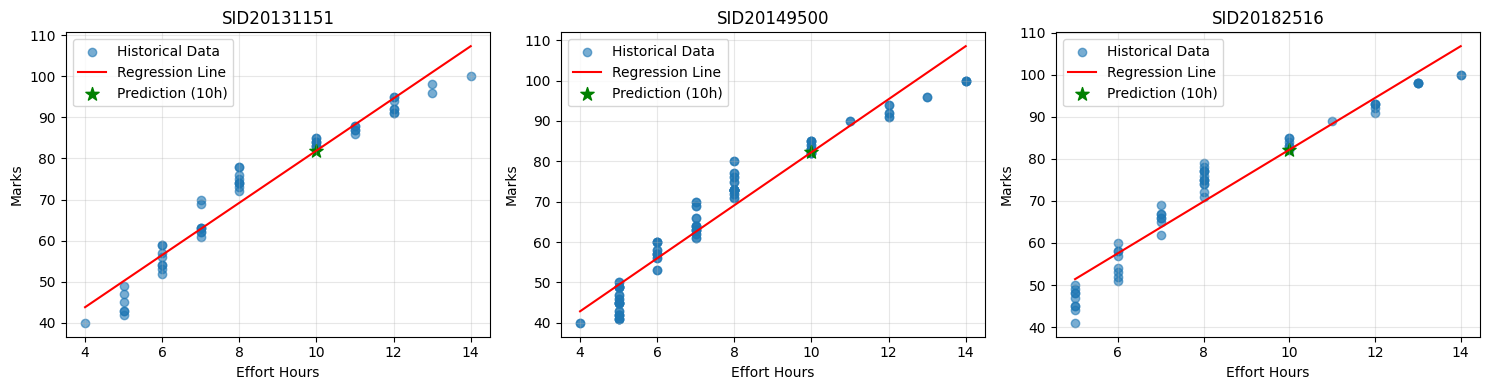

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, student_id in enumerate(TARGET_STUDENTS):
    student_data = clean_df[
        (clean_df["Student_ID"] == student_id) & 
        (clean_df["Effort_Hours"].notna()) & 
        (clean_df["Marks"].notna())
    ]
    
    if len(student_data) >= 2:
        # Fit model
        X = student_data[["Effort_Hours"]].values
        y = student_data["Marks"].values
        model = LinearRegression()
        model.fit(X, y)
        
        # Create regression line
        X_line = np.linspace(X.min(), max(X.max(), 10), 100)
        y_line = model.predict(X_line.reshape(-1, 1))
        
        # Plot
        axes[idx].scatter(X, y, alpha=0.6, label='Historical Data')
        axes[idx].plot(X_line, y_line, 'r-', label='Regression Line')
        axes[idx].scatter([10], [model.predict([[10]])[0]], 
                         color='green', s=100, marker='*', 
                         label='Prediction (10h)')
        axes[idx].set_xlabel('Effort Hours')
        axes[idx].set_ylabel('Marks')
        axes[idx].set_title(f'{student_id}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "student_regression_fits.png"), dpi=300, bbox_inches="tight")
plt.show()



### Export predictions
### - Saves final predictions CSV for submission.

In [5]:

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create final output with required columns
final_output = predictions_df[[
    "Student_ID", 
    "Predicted_Mark", 
    "Department_ID", 
    "Department_Name"
]].copy()

# Rename for clarity
final_output.columns = [
    "Student_ID",
    "Predicted Score in next paper",
    "Department_ID",
    "Department"
]

output_path = os.path.join(OUTPUT_DIR, "predicted_marks.csv")
final_output.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")
print("\nFinal Output:")
display(final_output)

Predictions saved to: outputs/predicted_marks.csv

Final Output:


,Student_ID,Predicted Score in next paper,Department_ID,Department
0,SID20131151,81.92,IDEPT6347,Sophisticated Analytical Instrument Facility (...
1,SID20149500,82.25,IDEPT4308,Climate Studies
2,SID20182516,82.17,IDEPT3062,Centre for Environmental Science and Engineeri...
